In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import numpy as np
import folium
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="vansh@11singH",
    database="demo2_msql_english")

cur = db.cursor()

In [3]:
query = """select * from demo2_msql_english.business_id"""

cur.execute(query)

data = cur.fetchall()

business_id = pd.DataFrame(data, columns = [['business_id', 'name',	'address',	'city',	'state', 'postal_code',	'latitude',	'longitude', 'stars',	
                                    'review_count', 'is_open',	'attributes','categories',	'hours']])
business_id.head(2)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.9555,-75.1556,4.0,80,1,"{""RestaurantsDelivery"": ""False"", ""OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{""Monday"": ""7:0-20:0"", ""Tuesday"": ""7:0-20:0"", ..."
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.2696,-87.0589,2.0,6,1,"{""BusinessParking"": ""None"", ""BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{""Monday"": ""0:0-0:0"", ""Tuesday"": ""6:0-22:0"", ""..."


In [4]:
query = """SELECT name, sum(review_count) as Total_Review, avg(stars) as Average_Rating 
FROM demo2_msql_english.business_id group by name order by Total_Review desc limit 10"""

cur.execute(query)

data = cur.fetchall()

Top_Restaurant_by_Review = pd.DataFrame(data, columns = [['Restaurant', 'Total Review', 'Average_Rating']])
Top_Restaurant_by_Review

,Restaurant,Total Review,Average_Rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,Taco Bell,8017,2.141813
3,Chick-fil-A,7711,3.369427
4,First Watch,6761,3.875000
5,Panera Bread,6613,2.661905
6,Buffalo Wild Wings,6483,2.344828
7,Domino's Pizza,6091,2.290210
8,Wendy's,5930,2.030159
9,Chili's,5754,2.500000


In [80]:
query = """SELECT name, sum(review_count) as Total_Review, avg(stars) as Average_Rating 
FROM demo2_msql_english.business_id group by name order by Average_Rating desc limit 10"""

cur.execute(query)

data = cur.fetchall()

Top_Restaurant_by_Rating = pd.DataFrame(data, columns = [['Restaurant', 'Total Review', 'Average_Rating']])
Top_Restaurant_by_Rating

,Restaurant,Total Review,Average_Rating
0,Volpi Foods,40,5.0
1,Constant Smoke BBQ,65,5.0
2,Vanessa Cafe Restaraunt Pizzeria,15,5.0
3,Enchanted Cat Cafe,8,5.0
4,Taqueria Don Quezadillas Belinda,14,5.0
5,Julis Mexican Restaurant,13,5.0
6,Jet City Espresso Hyde Park,152,5.0
7,Cheers Cafe,6,5.0
8,My Crazy Uncle Seafood,12,5.0
9,Jiffy Food Stores,14,5.0


In [77]:
query = """
SELECT min(review_count) as Minimum_Review,
       max(review_count) as Maximum_Review,
       avg(review_count) as Average_Review,
       min(stars) as Minimum_Rating,
       max(stars) as Maximum_Rating,
       avg(stars) as Average_Rating
FROM demo2_msql_english.business_id
"""
cur.execute(query)
data = cur.fetchall()

Rewview_rating = pd.DataFrame(
    data,
    columns=['Minimum_Review', 'Maximum_Review', 'Average_Review',
             'Minimum_Rating', 'Maximum_Rating', 'Average_Rating']
)

# Step 2: Median Review
query = "SELECT review_count FROM demo2_msql_english.business_id"
cur.execute(query)
data = cur.fetchall()
Rewview_count = pd.DataFrame(data, columns=['review_count'])
median_review = Rewview_count['review_count'].median()

# Step 3: Median Rating
query = "SELECT stars FROM demo2_msql_english.business_id"
cur.execute(query)
data = cur.fetchall()
stars_count = pd.DataFrame(data, columns=['stars'])
median_rating = stars_count['stars'].median()

# Step 4: Insert median review right after Average_Review
col_pos_review = Rewview_rating.columns.get_loc("Average_Review") + 1
Rewview_rating.insert(col_pos_review, "Median_Review", median_review)

# Step 5: Insert median rating right after Average_Rating
col_pos_rating = Rewview_rating.columns.get_loc("Average_Rating") + 1
Rewview_rating.insert(col_pos_rating, "Median_Rating", median_rating)

# Step 6: Transpose for vertical display
Rewview_rating_vertical = Rewview_rating.T.reset_index()
Rewview_rating_vertical.columns = ["Metric", "Value"]

# Step 7: Round numbers
Rewview_rating_vertical["Value"] = Rewview_rating_vertical["Value"].round(2)

# Step 8: Style headers bold
styled_table = (
    Rewview_rating_vertical.style
    .set_table_styles(
        [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
    )
    .hide(axis="index")
)

styled_table

Metric,Value
Minimum_Review,5
Maximum_Review,248
Average_Review,55.9754
Median_Review,33.000000
Minimum_Rating,1.000000
Maximum_Rating,5.000000
Average_Rating,3.477281
Median_Rating,3.500000


# Do restaurents with higher engagement tend to have hgher ratings?

In [4]:
query = """with cte as
(SELECT business_id, stars, review_count 
FROM demo2_msql_english.business_id),
cte1 as
(SELECT 
    business_id,
    SUM(LENGTH(`checkin_date`) - LENGTH(REPLACE(`checkin_date`, ', ', '')) + 1) AS Total_checkin
FROM new_checkin
GROUP BY business_id
ORDER BY Total_checkin ASC),
cte2 as
(SELECT business_id, count(*) as tip_cnt
FROM demo2_msql_english.tip group by business_id),
cte3 as
(select c.business_id,
avg(c.stars) as rating,
sum(c.review_count) as review,
sum(c1.Total_checkin) as checkin,
sum(tip_cnt) as tip
from cte c left join cte1 c1
on c.business_id = c1.business_id
left join cte2 c2
on c2.business_id = c.business_id
group by c.business_id)

select rating, round(avg(review),0) as review, round(avg(checkin),0) as chekin, round(avg(tip),0) as tip
from cte3 group by rating order by rating"""

cur.execute(query)

data = cur.fetchall()   

review_cnt_rating = pd.DataFrame(data, columns = ['rating', 'review', 'checkin', 'tip'])
review_cnt_rating

,rating,review,checkin,tip
0,1.0,14,34,3
1,1.5,24,68,4
2,2.0,28,104,5
3,2.5,37,158,6
4,3.0,48,211,8
5,3.5,64,251,10
6,4.0,73,253,11
7,4.5,65,171,9
8,5.0,31,54,4


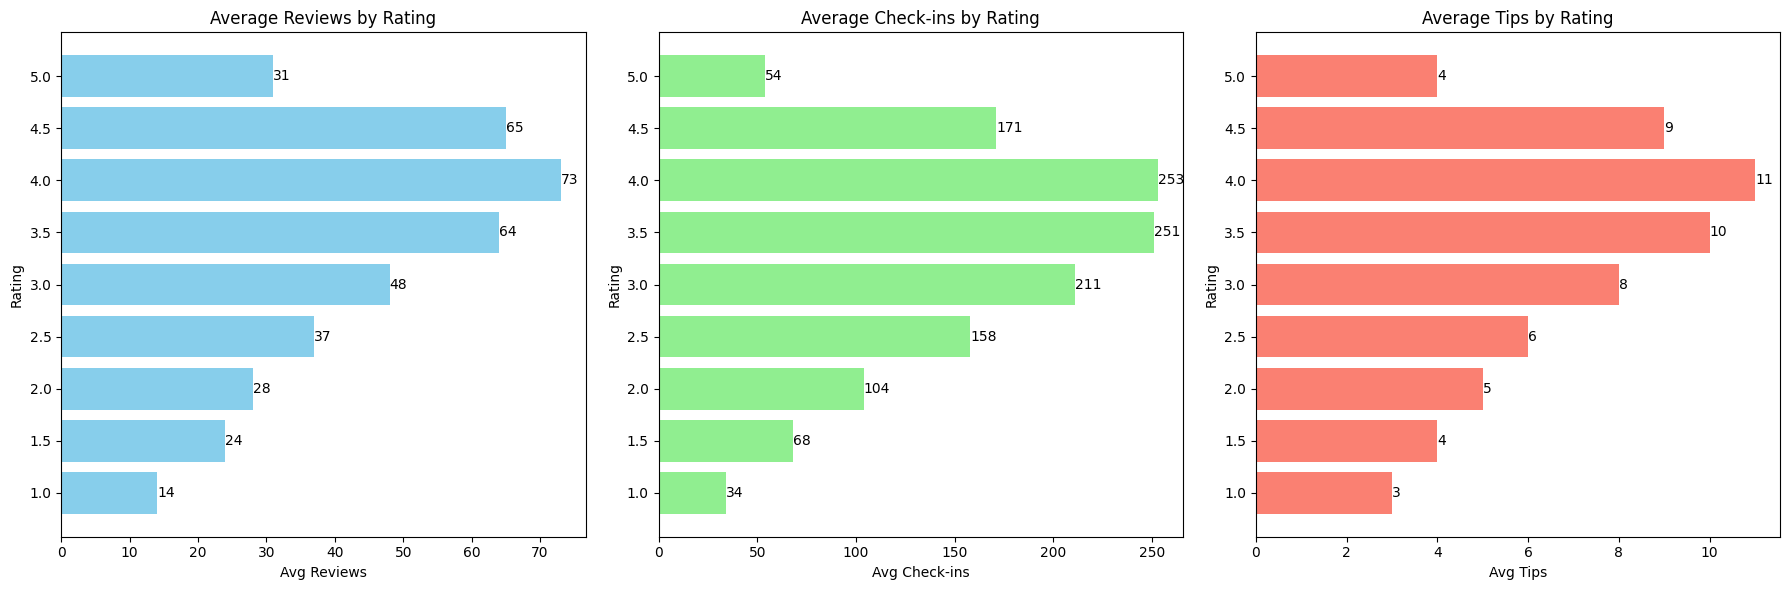

In [15]:
df_grouped = review_cnt_rating.sort_values("rating")
df_grouped["rating"] = df_grouped["rating"].astype(str)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot 1 - Reviews
bars1 = axes[0].barh(df_grouped["rating"], df_grouped["review"], color="skyblue")
axes[0].set_title("Average Reviews by Rating")
axes[0].set_xlabel("Avg Reviews")
axes[0].set_ylabel("Rating")
axes[0].bar_label(bars1, fmt="%.0f")

# Plot 2 - Check-ins (fixed column name)
bars2 = axes[1].barh(df_grouped["rating"], df_grouped["checkin"], color="lightgreen")
axes[1].set_title("Average Check-ins by Rating")
axes[1].set_xlabel("Avg Check-ins")
axes[1].set_ylabel("Rating")
axes[1].bar_label(bars2, fmt="%.0f")

# Plot 3 - Tips
bars3 = axes[2].barh(df_grouped["rating"], df_grouped["tip"], color="salmon")
axes[2].set_title("Average Tips by Rating")
axes[2].set_xlabel("Avg Tips")
axes[2].set_ylabel("Rating")
axes[2].bar_label(bars3, fmt="%.0f")

# ✅ Force y-axis tick labels to show on all charts
for ax in axes:
    ax.tick_params(labelleft=True)   # show y tick labels
    ax.set_yticks(range(len(df_grouped["rating"])))
    ax.set_yticklabels(df_grouped["rating"])

plt.tight_layout()
plt.show()

# Is there a correlation between reviews numbers and checkins?

In [12]:
query = """with cte as
(SELECT business_id, stars, review_count,
case when stars >= 3.5 then 'High Rated' else 'Low Rated' end as category
FROM demo2_msql_english.business_id),
cte1 as
(SELECT 
    business_id,
    SUM(LENGTH(`checkin_date`) - LENGTH(REPLACE(`checkin_date`, ', ', '')) + 1) AS Total_checkin
FROM new_checkin
GROUP BY business_id
ORDER BY Total_checkin ASC),
cte2 as
(SELECT business_id, count(*) as tip_cnt
FROM demo2_msql_english.tip group by business_id),
cte3 as
(select c.business_id, c.category,
avg(c.stars) as rating,
sum(c.review_count) as review,
sum(c1.Total_checkin) as checkin,
sum(tip_cnt) as tip
from cte c left join cte1 c1
on c.business_id = c1.business_id
left join cte2 c2
on c2.business_id = c.business_id
group by c.business_id, c.category order by review asc)


select * from cte3"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['business_id', 'category', 'rating', 'review', 'checkin', 'tip'])
df.dropna()

,business_id,category,rating,review,checkin,tip
2,67FYIjs8KARCkMDgiDVDDw,Low Rated,3.0,5,43,1
8,_8QkK3WwGxNnn54Q1VTTcA,High Rated,5.0,5,43,1
10,kei6KHKxuNF1nlm7akQA-Q,High Rated,4.0,5,39,1
15,XqGNxBmAo2Jm5DibhJcrOQ,High Rated,3.5,5,53,1
22,5wo7nNHOvfzt2c-PG0BUKQ,Low Rated,3.0,5,63,2
...,...,...,...,...,...,...
31532,MTB9CelShC-x4jj31BJYAg,High Rated,3.5,248,779,16
31533,s3ZR7G5l-YN5fqms8vRSRw,High Rated,4.0,248,1531,49
31534,9iSoPNBV54dj6L0rxO4RWw,High Rated,3.5,248,437,7
31535,30OhTA38fp8xuqW4O2D6Eg,High Rated,4.0,248,591,14


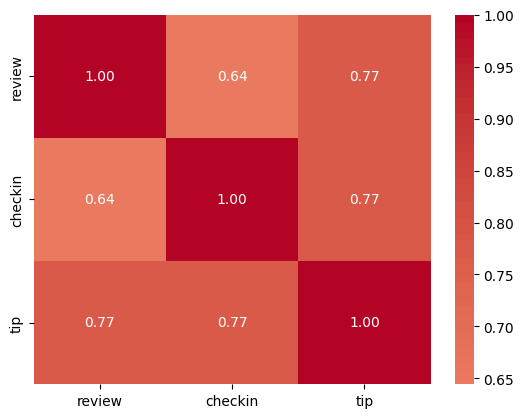

In [13]:
corr_matrix = df[['review', 'checkin', 'tip']].corr(method="pearson")

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.show()

# Is there a difference in the user engagement (reviews, tips, and check-ins) between high-rated and low-rated businesses?

In [14]:
user_engagment = df.groupby('category')[['review', 'checkin', 'tip']].mean()
user_engagment

,review,checkin,tip
category,,,
High Rated,65.785335,221.151141,10.113025
Low Rated,37.726646,157.0,6.506592


# Is there a difference in the user engagement (reviews, tips, and check-ins) between high-rated and low-rated businesses?

In [29]:
def calculate_success_metric(df):
    success_score = []
    for index, row in df.iterrows():
        score = float(row['average_rating']) * np.log(float(row['total_review']) + 1)
        success_score.append(score)
    return success_score

In [30]:
query = """SELECT city, state,
       AVG(latitude) AS latitude,
       AVG(longitude) AS longitude,
       SUM(review_count) AS total_review,
       AVG(stars) AS average_rating,
       COUNT(*) AS restaurant_count
FROM demo2_msql_english.business_id
GROUP BY city, state
ORDER BY total_review DESc limit 10"""

cur.execute(query)

data = cur.fetchall()

city_df = pd.DataFrame(data, columns = ['city', 'state', 'latitude', 'longitude', 'total_review', 'average_rating', 'restaurant_count'])
city_df

city_df = city_df.astype({
    "total_review": "float",
    "average_rating": "float",
    "restaurant_count": "int"
})
city_df['Success Score'] = calculate_success_metric(city_df)
city_df

,city,state,latitude,longitude,total_review,average_rating,restaurant_count,Success Score
0,Philadelphia,PA,39.982274,-75.150003,175606.0,3.532312,3002,42.656211
1,Tampa,FL,28.001731,-82.476943,104751.0,3.568274,1721,41.246934
2,Indianapolis,IN,39.802349,-86.141398,92639.0,3.412111,1701,39.022521
3,Tucson,AZ,32.233891,-110.936402,91672.0,3.383885,1421,38.664208
4,Nashville,TN,36.142252,-86.770107,87100.0,3.491465,1406,39.714800
5,New Orleans,LA,29.961270,-90.075372,69309.0,3.694472,1013,41.179856
6,Saint Louis,MO,38.616387,-90.302794,51490.0,3.414303,811,37.042331
7,Reno,NV,39.507601,-119.806460,48569.0,3.479695,591,37.548563
8,Edmonton,AB,53.526310,-113.514226,45986.0,3.509367,1548,37.676963
9,Boise,ID,43.608537,-116.239164,36104.0,3.558824,561,37.346958


In [31]:
import branca
from matplotlib.colors import LinearSegmentedColormap


# Color function - fixed
def get_color(score, min_score, max_score):
    norm = (score - min_score) / (max_score - min_score) if max_score > min_score else 0.5
    cmap = LinearSegmentedColormap.from_list('score_scale', ['red', 'yellow', 'green'])
    rgb = cmap(norm)[:3]
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

min_score = city_df['Success Score'].min()
max_score = city_df['Success Score'].max()

mean_lat, mean_lon = city_df['latitude'].mean(), city_df['longitude'].mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=5)

# Add city markers
for idx, row in city_df.iterrows():
    color = get_color(row['Success Score'], min_score, max_score)
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=max(5, row['Success Score']/10),
        popup=(f"<b>{row['city']}, {row['state']}</b><br>"
               f"Success Score: {row['Success Score']:.2f}<br>"
               f"Total Reviews: {row['total_review']}<br>"
               f"Avg Rating: {row['average_rating']:.2f}<br>"
               f"Restaurant Count: {row['restaurant_count']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(m)

# Add legend using branca
colormap = branca.colormap.LinearColormap(['red', 'yellow', 'green'],
                                          vmin=min_score, vmax=max_score,
                                          caption='Success Score')
m.add_child(colormap)
display(m)

# Are there any patterns in user engagement over time for successful businesses compared to less successful ones?

In [17]:
query = """with cte as
(SELECT date_format(checkin_date, '%m-%Y') as date, count(*) as review_count
FROM demo2_msql_english.reviews r join demo2_msql_english.business_id b
on r.business_id = b.business_id and r.stars >= 3.5
group by date order by date),
cte1 as
(SELECT date_format(checkin_date, '%m-%Y') as date, count(*) as tip_count
FROM demo2_msql_english.tip t join demo2_msql_english.business_id b
on t.business_id = b.business_id and b.stars >= 3.5
group by date order by date)

select c.date, c.review_count, c1.tip_count
from cte c join cte1 c1
on c.date = c1.date"""

cur.execute(query)

data = cur.fetchall()

higher_rating = pd.DataFrame(data, columns = ['Date', 'Review_count', 'Tip_count'])
higher_rating

,Date,Review_count,Tip_count
0,01-2010,1218,79
1,01-2011,2171,621
2,01-2012,3086,1321
3,01-2013,3801,1230
4,01-2014,4973,1357
...,...,...,...
149,12-2017,10161,1477
150,12-2018,12870,1163
151,12-2019,13756,1161
152,12-2020,11294,937


In [16]:
query = """with cte as
(SELECT date_format(checkin_date, '%m-%Y') as date, count(*) as review_count
FROM demo2_msql_english.reviews r join demo2_msql_english.business_id b
on r.business_id = b.business_id and r.stars < 3.5
group by date order by date),
cte1 as
(SELECT date_format(checkin_date, '%m-%Y') as date, count(*) as tip_count
FROM demo2_msql_english.tip t join demo2_msql_english.business_id b
on t.business_id = b.business_id and b.stars < 3.5
group by date order by date)

select c.date, c.review_count, c1.tip_count
from cte c join cte1 c1
on c.date = c1.date"""

cur.execute(query)

data = cur.fetchall()

lower_rating = pd.DataFrame(data, columns = ['Date', 'Review_count', 'Tip_count'])
lower_rating

,Date,Review_count,Tip_count
0,01-2010,613,25
1,01-2011,1103,297
2,01-2012,1748,538
3,01-2013,2196,548
4,01-2014,2769,607
...,...,...,...
149,12-2017,5970,441
150,12-2018,7574,338
151,12-2019,7591,275
152,12-2020,5014,148


In [18]:
query = """SELECT date_format(checkin_date, '%m-%Y') as Month_Year, avg(stars) as average_rating
FROM demo2_msql_english.reviews
group by Month_Year order by Month_Year"""

cur.execute(query)

data = cur.fetchall()

time_average_rating = pd.DataFrame(data, columns = ['Month_Year', 'average_rating'])
time_average_rating

,Month_Year,average_rating
0,01-2006,4.0000
1,01-2007,3.8974
2,01-2008,3.6040
3,01-2009,3.6907
4,01-2010,3.7242
...,...,...
198,12-2017,3.6134
199,12-2018,3.6087
200,12-2019,3.6652
201,12-2020,3.8337


In [19]:
time_average_rating['Month_Year'] = pd.to_datetime(time_average_rating['Month_Year'], format='%m-%Y')
time_average_rating['average_rating'] = time_average_rating['average_rating'].astype('float64')
time_average_rating.sort_values('Month_Year', ascending = True)
time_average_rating = time_average_rating[time_average_rating['Month_Year'] > '2017']
time_average_rating.head(2)

,Month_Year,average_rating
12,2018-01-01,3.7067
13,2019-01-01,3.7193


In [20]:
higher_rating['Date'] = pd.to_datetime(higher_rating['Date'], format='%m-%Y')
higher_rating.sort_values('Date', ascending = True)
higher_rating = higher_rating[higher_rating['Date']> '2017']
higher_rating

,Date,Review_count,Tip_count
8,2018-01-01,12091,1404
9,2019-01-01,14320,1319
10,2020-01-01,14841,1257
11,2021-01-01,12575,1061
12,2022-01-01,8221,328
20,2017-02-01,9607,1677
21,2018-02-01,11652,1433
22,2019-02-01,13668,1300
23,2020-02-01,15428,1195
24,2021-02-01,11604,916


In [21]:
lower_rating['Date'] = pd.to_datetime(higher_rating['Date'], format='%m-%Y')
lower_rating.sort_values('Date', ascending = True)
lower_rating = lower_rating[lower_rating['Date']> '2017']
lower_rating.head(2)

,Date,Review_count,Tip_count
8,2018-01-01,6328,380
9,2019-01-01,7469,315


In [22]:
high_tip = higher_rating.groupby('Date')['Tip_count'].sum()
low_tip = lower_rating.groupby('Date')['Tip_count'].sum()

high_review = higher_rating.groupby('Date')['Review_count'].sum()
low_review = lower_rating.groupby('Date')['Review_count'].sum()

time_average_mean = time_average_rating.groupby('Month_Year')['average_rating'].mean()

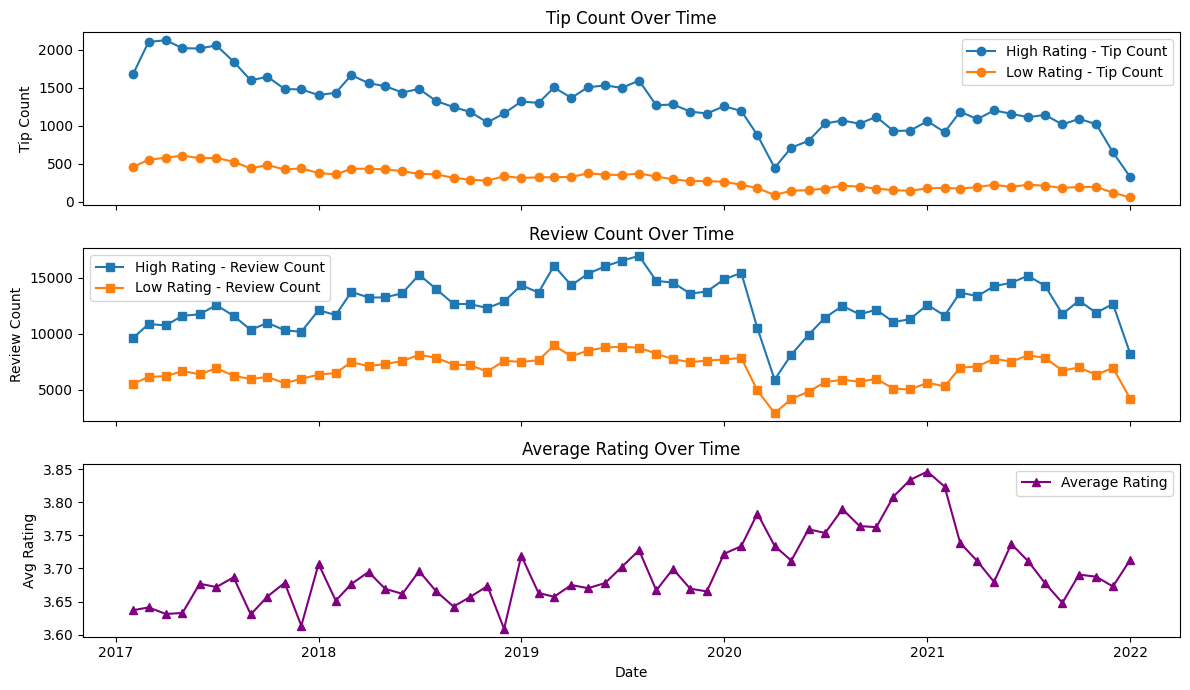

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

# 1️⃣ Plot Tip Counts
axes[0].plot(high_tip.index, high_tip.values, label="High Rating - Tip Count", marker="o")
axes[0].plot(low_tip.index, low_tip.values, label="Low Rating - Tip Count", marker="o")
axes[0].set_title("Tip Count Over Time")
axes[0].set_ylabel("Tip Count")
axes[0].legend()

# 2️⃣ Plot Review Counts
axes[1].plot(high_review.index, high_review.values, label="High Rating - Review Count", marker="s")
axes[1].plot(low_review.index, low_review.values, label="Low Rating - Review Count", marker="s")
axes[1].set_title("Review Count Over Time")
axes[1].set_ylabel("Review Count")
axes[1].legend()

# 3️⃣ Plot Average Rating
axes[2].plot(time_average_mean.index, time_average_mean.values, label="Average Rating", color="purple", marker="^")
axes[2].set_title("Average Rating Over Time")
axes[2].set_ylabel("Avg Rating")
axes[2].set_xlabel("Date")
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


# Is there any difference in engagement elit user and non elit user?

In [25]:
query = """select category, count(*) as Class_cnt, sum(review_count) as Total_review from 
(SELECT *,
case when elite is null then 'Not Elite' else 'Elite' end as category 
FROM demo2_msql_english.user) as a
group by category"""

cur.execute(query)

data = cur.fetchall()

Elite = pd.DataFrame(data, columns = ['Class', 'Elite Count', 'Total Review'])
Elite.head(2)

,Class,Elite Count,Total Review
0,Elite,91198,20484441
1,Not Elite,1896699,26021235


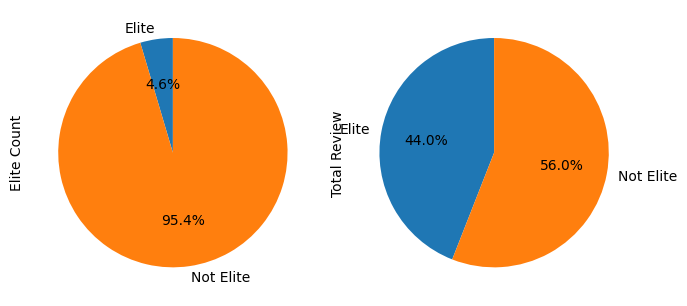

In [26]:
data = {
    "Class": ["Elite", "Not Elite"],
    "Elite Count": [91198, 1896699],
    "Total Review": [20484441, 26021235]
}
df = pd.DataFrame(data).set_index("Class")

# Two pie charts side by side
axes = df.plot.pie(
    subplots=True,
    autopct="%1.1f%%",
    figsize=(7,5),   # <-- set size here
    startangle=90,
    legend=False
)

plt.tight_layout()
plt.show()

# Busiest Hours

In [40]:
from datetime import datetime

query = """SELECT * FROM demo2_msql_english.new_checkin"""

cur.execute(query)

data = cur.fetchall()

chekin_hour = pd.DataFrame(data, columns = ['Business_id', 'Checkin_date'])
checkin_engagement = []

for i in chekin_hour['Checkin_date']:
    checkin_engagement.extend([
        datetime.strptime(j.strip(), "%Y-%m-%d %H:%M:%S").strftime("%H")
        for j in i.split(',')
    ])

checkin_engagement = pd.DataFrame(checkin_engagement).astype('int').groupby(0)[0].count()
checkin_engagement

0
0     286856
1     217994
2     143484
3      88326
4      51467
5      30465
6      17535
7      11078
8       7004
9       6209
10     12210
11     25768
12     47071
13     68059
14     87997
15    131986
16    221195
17    259187
18    238766
19    205320
20    180634
21    199833
22    259934
23    305080
Name: 0, dtype: int64

In [43]:
query = """SELECT hour(checkin_date) as hours, count(*) as review_count 
FROM demo2_msql_english.reviews group by hours order by hours"""

cur.execute(query)

data = cur.fetchall()

Review_Engagement = pd.DataFrame(data, columns = ['Hours', 'Rewview_count'])
Review_Engagement

,Hours,Rewview_count
0,0,137991
1,1,134466
2,2,116041
3,3,89608
4,4,62366
5,5,39618
6,6,24310
7,7,14655
8,8,9661
9,9,7910


In [45]:
query = """SELECT hour(checkin_date) as hours, count(*) as tip_count 
FROM demo2_msql_english.tip group by hours order by hours"""

cur.execute(query)

data = cur.fetchall()

Tip_Engagement = pd.DataFrame(data, columns = ['Hours', 'Tip_count'])
Tip_Engagement

,Hours,Tip_count
0,0,21535
1,1,18808
2,2,14562
3,3,10319
4,4,6851
5,5,4193
6,6,2747
7,7,1754
8,8,1195
9,9,930


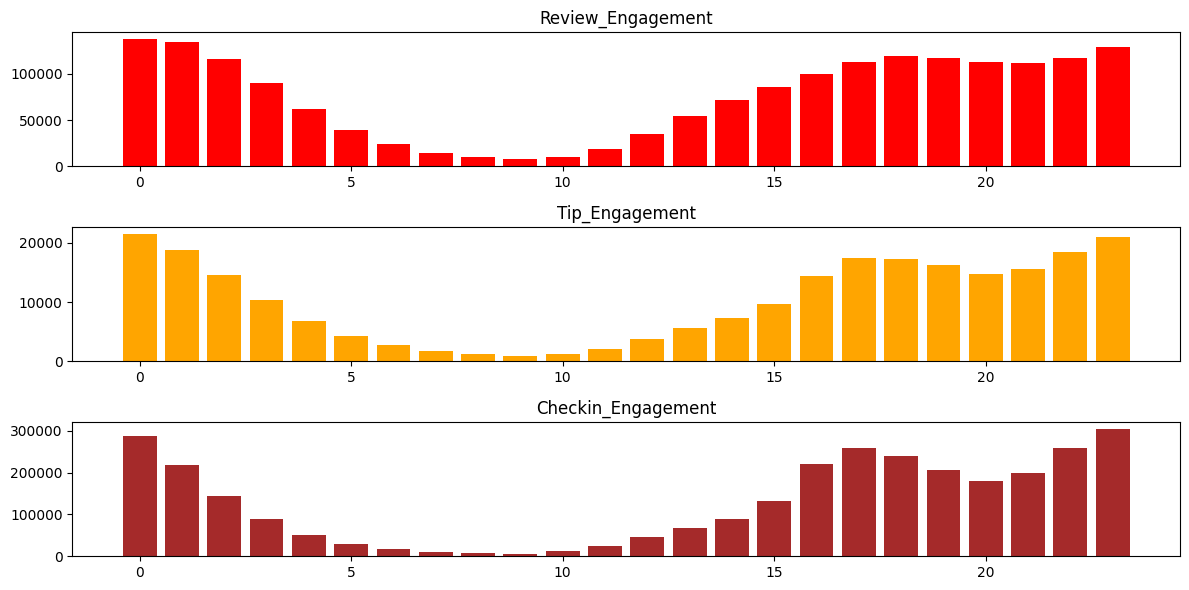

In [50]:
plt.figure(figsize = (12, 6))
plt.subplot(3,1,1)
plt.title('Review_Engagement')
plt.bar(Review_Engagement['Hours'], Review_Engagement['Rewview_count'], color = 'red')
plt.subplot(3,1,2)
plt.title('Tip_Engagement')
plt.bar(Tip_Engagement['Hours'], Tip_Engagement['Tip_count'], color = 'orange')
plt.subplot(3,1,3)
plt.title('Checkin_Engagement')
plt.bar(checkin_engagement.index, checkin_engagement.values, color = 'brown')
plt.tight_layout()
plt.show()